In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
# import seaborn as sns
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import glob as glob
# import arrow
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
def split_data(data):
    train_mask = (data.index < "2009")
    train = data[train_mask].cases
    test_mask = (data.index > "2009")
    test = data[test_mask].cases
    return train, test

In [88]:
weekly_df = pd.read_csv("dengue-cases.csv",index_col=False)
weekly_df = weekly_df.set_index('date')
# weekly_df = weekly_df.iloc[209:]
weekly_df.index = pd.DatetimeIndex(weekly_df.index)
train_test_mask = weekly_df.index > "2006"
train_test = weekly_df[train_test_mask].cases
train_mask = (weekly_df.index > "2006") & (weekly_df.index < "2011")
train = weekly_df[train_mask].cases
test_mask = (weekly_df.index > "2011")
test = weekly_df[test_mask].cases

In [3]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week,label="prediction")
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\theta\,(w_{i}\cdot x_{i}) = \frac{1}{1\,+\,e^{-\sum_{i=0}^{n} w_{i} x_{i}}}$$

$$Seasonal\,Part_{1} = \,s_{0}* \,\sin(\dfrac{\pi\,x}{52}) \, + \,s_{0}$$

$$Seasonal\,Part_{2} =\,\cos^2(k\,x +\, \phi) + c$$

$$Seasonal\,Part_{3} =\,\cos^2(k\,x  +\, \phi\dfrac{\pi}{52}) + c$$

$$Seasonal\,Part_{4} =\,\cos^2(k\,x  +\, \phi\dfrac{\pi}{52}) + c$$

$$Seasonal\,Part_{5} =\,\cos^2(\dfrac{\pi}{52}\,(x + c)) + k$$

$$\log cases = \log pop. + \log\,\theta(w\cdot x) \,+ Seasonal\,Part$$

For forecasts of future values in period T + r on the original scale. if a transformation was used, say, x1 = In y, then the forecast made at the end of period T for T + r would be obtained by reversing the transformation. For the natural log this would be to exponetiate it back

## maximize for all betas values is needed
- the cases part needs lag + 1
- the population which is float needs 1
- the seasonality part needs 3

if we have 26 lags to predict for the next week, we would have to maximize for a set of 31 betas

In [121]:
from scipy.special import expit
from scipy.optimize import fmin, minimize

LAG = 26
W_CASE = LAG + 1
W_POP = 1
W_SEASON = 3
BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

# starting point of phi should be 30,
# and
def season(w,x):
#     thr_yr = 3*52
#     pi = np.math.pi
#     sine = np.math.sin((pi*x)/float(52))
#     return w[-2]*(sine) + w[-2]
    pi = np.math.pi
    coeff = pi/52.
    inside = coeff*(x + w[-2])
    cosine_sq = np.math.cos(inside)**2
    return (cosine_sq) + w[-3]

def theta(w,y):
    pad_y = np.concatenate(([1],np.array(y)))
    score = np.dot(w[:-4],pad_y)
    return expit(score)

def guess(w,x_week,y_case):
    return np.log(theta(w,y_case)+ 1e-5) + season(w,x_week) + w[-1] # w[-3] + season

def cost(w):
    ret = 0
    for week_no in range(len(train)-W_CASE):
        real_case = np.log(train[week_no+W_CASE])
        predicted_case = guess(w,week_no,train[week_no:week_no+LAG])
        ret += (real_case - predicted_case)**2
#     print ret/float(len(train))
    return ret/float(len(train))

pi = np.math.pi
pop_starter = np.log(3000.)
seasonality_starters = [0,0,30] #[1500.,(pi/50),(20*pi / 52.)] # [amplitude,constant,period,phase]
arr = np.array([0.]*W_CASE) # 27 betas
arr = np.append(arr,seasonality_starters) # 31 betas
arr = np.append(arr,pop_starter) # 32 betas
w = minimize(cost,arr)


In [125]:
w

      fun: 0.03815040201591986
 hess_inv: array([[  3.85666639e+01,   1.94165137e-03,  -1.17910942e-03,
          3.38753547e-03,  -1.44017912e-03,  -1.40274706e-03,
          3.52528829e-03,  -4.28105778e-03,   5.79074926e-04,
          2.55225735e-03,   2.71998921e-03,  -2.75467652e-03,
         -1.63840099e-03,  -1.40744180e-03,  -2.51948027e-04,
          9.08233642e-03,  -5.50186168e-03,  -7.17596497e-04,
          9.77086223e-04,   1.16855080e-03,   1.00198699e-03,
          5.84247379e-05,  -8.40643876e-03,  -3.15881139e-03,
         -1.10953089e-03,   3.03688517e-03,   1.74364974e-02,
          0.00000000e+00,  -1.88582170e+01,  -8.05286455e+01,
         -1.88582170e+01],
       [  1.94165137e-03,   4.44887157e-05,  -4.20821040e-05,
         -4.32910343e-06,  -4.04139922e-06,   3.67699135e-06,
          1.10550514e-05,  -6.92445389e-06,   7.91456814e-06,
         -3.27800330e-06,  -1.09642899e-05,   6.38953356e-06,
         -1.16871328e-06,   8.53935488e-06,  -1.67220591e-05,
 

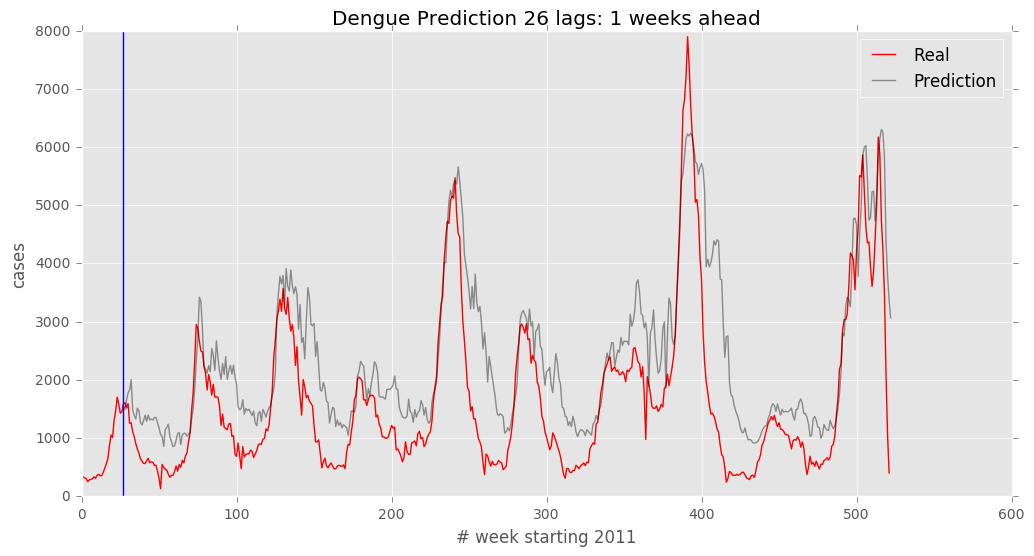

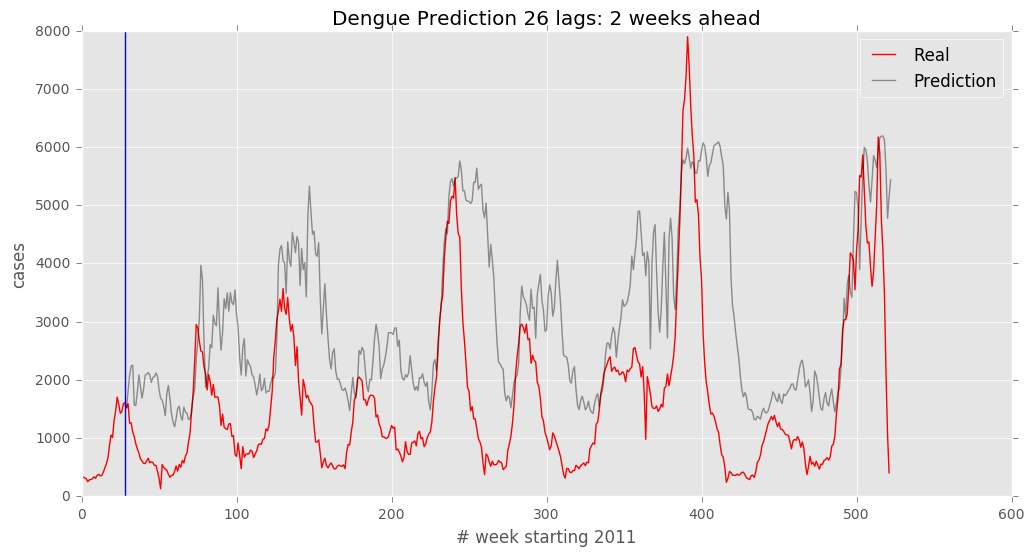

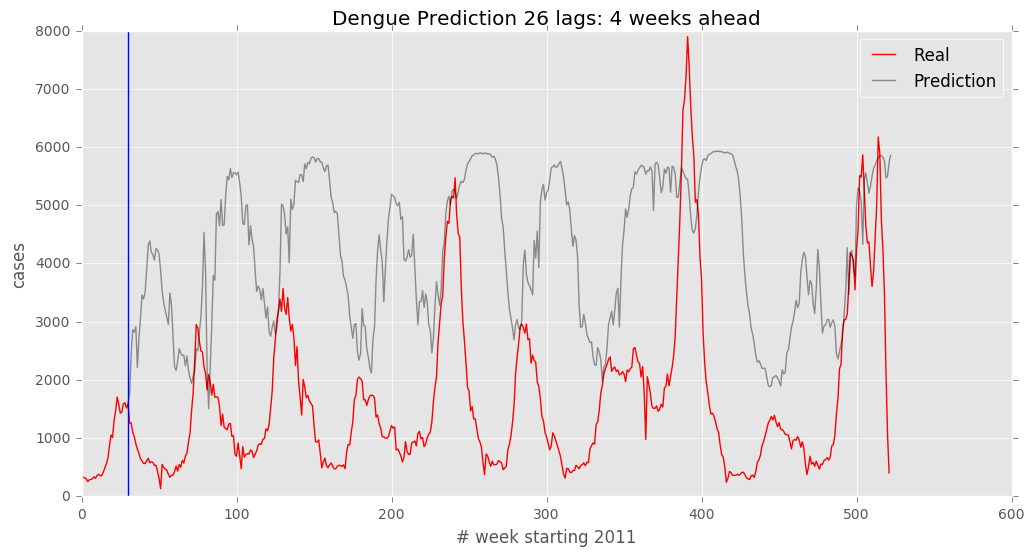

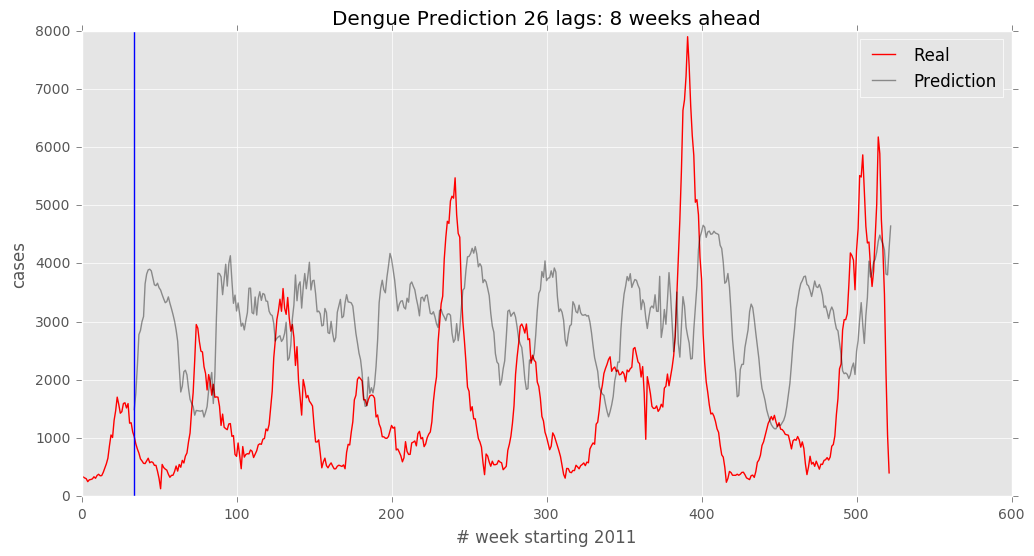

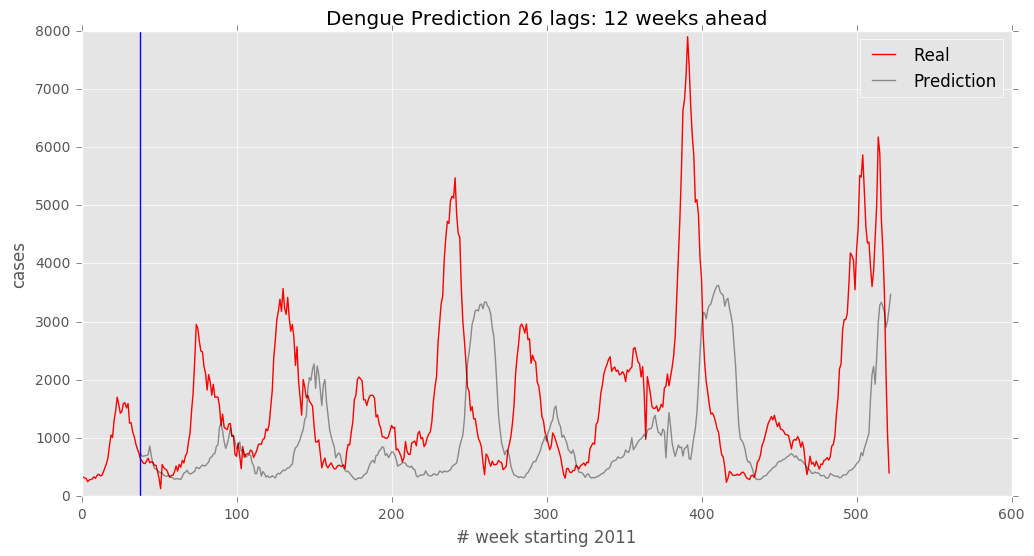

In [124]:
NWEEKS = 26

nweek_to_predict = [1,2,4,8,12]

def n_week_ahead(array_x,weeks_ahead):
    
    theta = 0
    arr = np.array(array_x)
    for week_no in range(weeks_ahead):
        theta = np.exp(guess(w.x,week_no,arr))
        arr = np.append(arr[1:],theta)
    return theta

all_predictions = []
for i in nweek_to_predict:
    N = NWEEKS + (i - 1)
    tmp = []
    for j in range(len(train_test)-N):
        initial_arr = train_test[j:j+NWEEKS]
        tmp.append(n_week_ahead(initial_arr,i))
    
    to_start = [0]*(NWEEKS+i)
    zeros_st = np.concatenate((to_start,tmp))
    all_predictions.append(zeros_st)
    title = 'Dengue Prediction %d lags: %d weeks ahead'%(NWEEKS,i)
    make_line(NWEEKS+i,train_test,tmp,title,"# week starting 2011","cases")
#     plt.axvline(len(train),linewidth=0.5, color='k')
#     plt.text(len(train+1),0,'train',horizontalalignment='center',verticalalignment='center')
        

In [84]:
without_seasonality_df = pd.read_csv('without-seasonality.csv')
without_seasonality_df = without_seasonality_df.drop("Unnamed: 0",axis=1)
with_seasonality_df = pd.DataFrame(all_predictions).T
with_seasonality_df.columns = ['1 week w/ season','2 week w/ season',
                               '4 week w/ season','8 week w/ season',
                               '12 week w/ season']
with_seasonality_df = with_seasonality_df.astype('f')
all_predictions_df = pd.concat([without_seasonality_df,with_seasonality_df],axis=1)
all_predictions_df = all_predictions_df.replace('0', np.nan)
# all_predictions_df

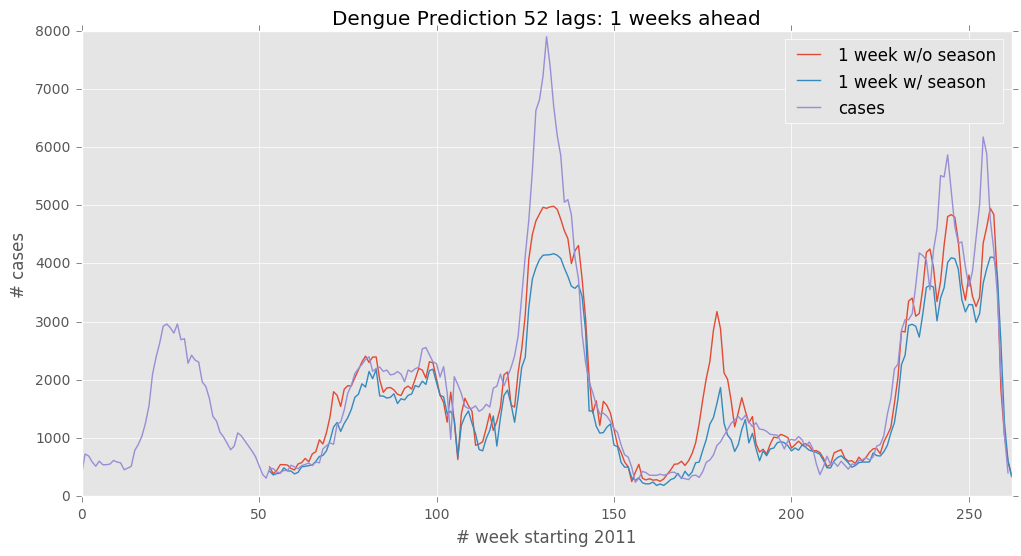

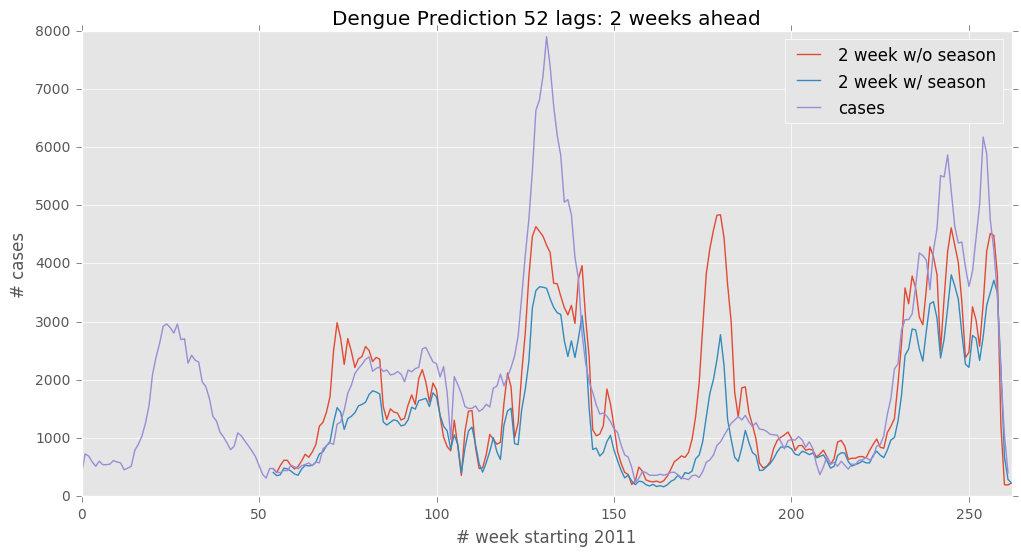

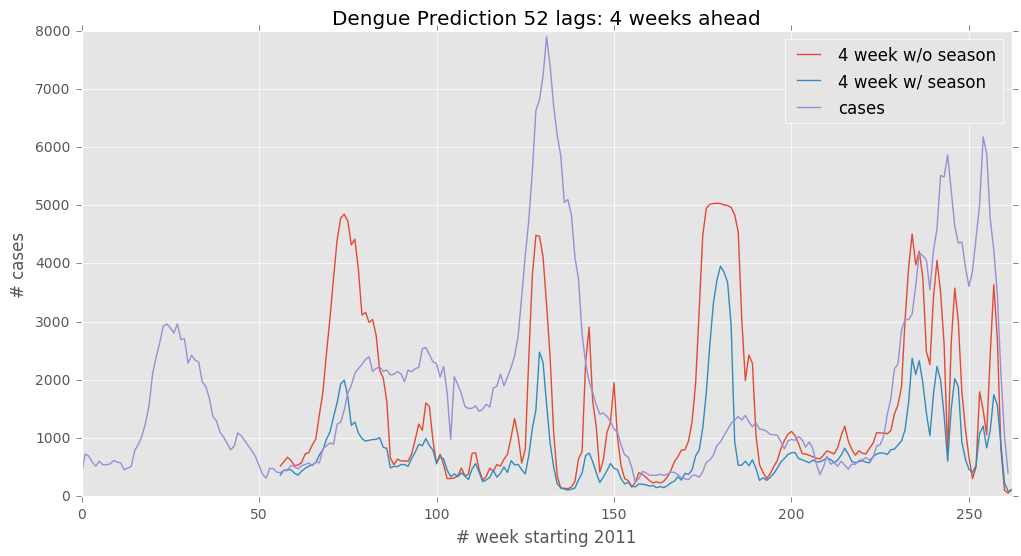

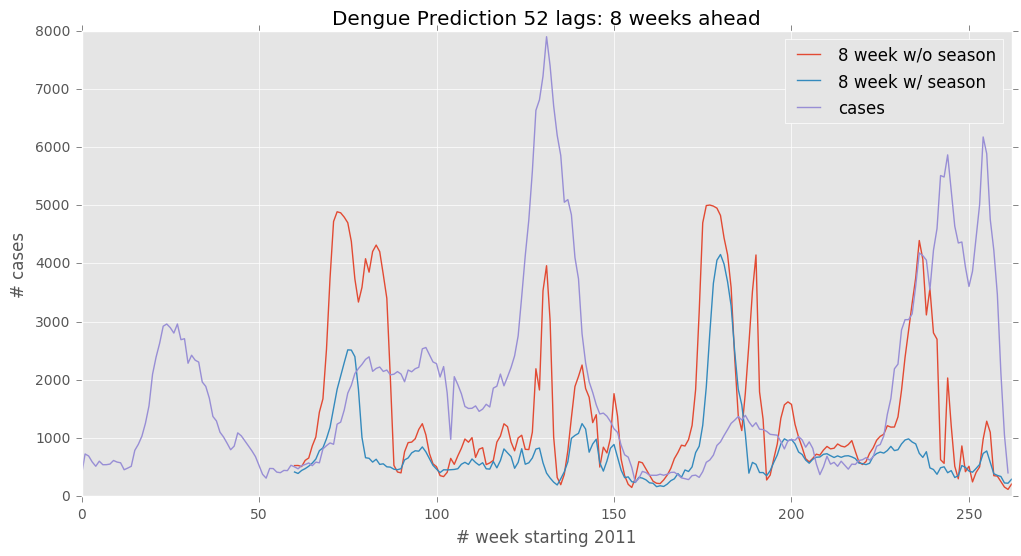

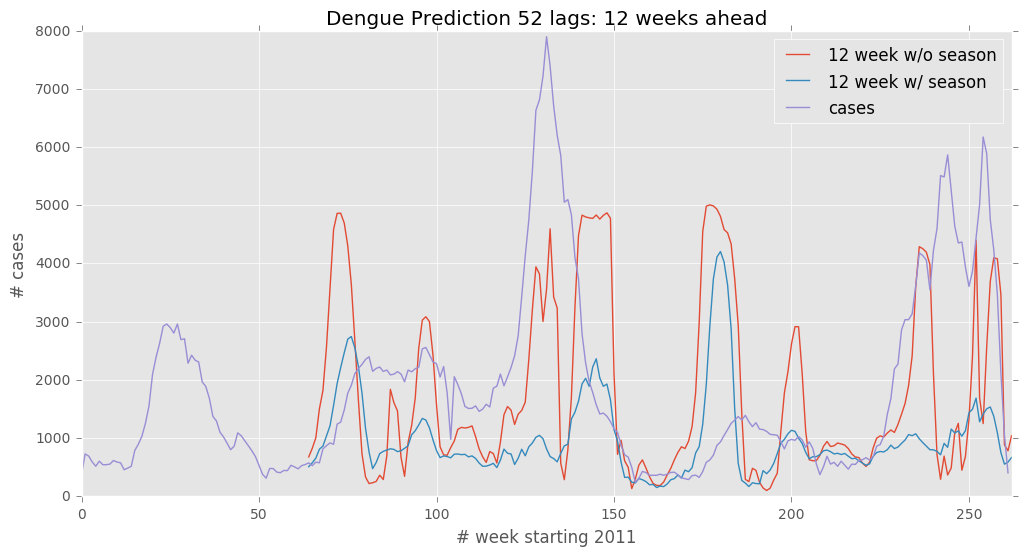

In [86]:
for week_ahead in nweek_to_predict:
    plt.figure(figsize=(12,6))
    without_season = '%d week w/o season'%week_ahead
    with_season = '%d week w/ season'%week_ahead
    all_predictions_df[without_season].plot()
    all_predictions_df[with_season].plot()
    plt.plot([i for i in range(len(test))],test)
    plt.xlabel("# week starting 2011")
    plt.ylabel("# cases")
    plt.legend()
    title = 'Dengue Prediction 52 lags: %d weeks ahead'%week_ahead
    plt.title(title)

In [113]:
plt.text?

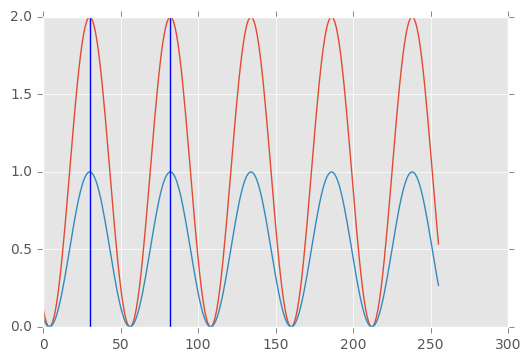

In [226]:
def trial01(wk_no):
    period = np.math.pi / 26
    inside = (period*wk_no) - ((30*np.math.pi / 26.))
    return np.math.cos(inside) + 1

def trial02(wk_no):
    period = np.math.pi / 52
    inside = (period*wk_no) - (30*np.math.pi / 52.)
    cosine_sq = np.math.cos(inside)**2
    return cosine_sq

idx = [i for i in range(128*2)]
idy = [trial01(i) for i in idx]
idyy = [trial02(i) for i in idx]

plt.plot(idx,idy,idx,idyy)
plt.axvline(30)
plt.axvline(82)

In [ ]:
BETAS_SET = lag + 1
ALL_WS = BETAS_SET + 1

def guess(w,x):
    def theta(w,x):
        pad_x = np.concatenate(([1],np.array(x)))
        score = np.dot(w[:-1],pad_x)
        return expit(score)

    return np.log(theta(w,x)+ 1e-5) + w[-1] 

def cost(w):
    ret = 0
    for i in range(len(train)-ALL_WS):
        real_case = np.log(train[i+ALL_WS])
        predicted_case = guess(w,train[i:i+lag])
        ret += (real_case - predicted_case)**2
    return ret/float(len(train))

starter = np.log(3000.)#np.log(7500.)
arr = np.array([0.]*BETAS_SET)
arr = np.append(arr,starter)
w = minimize(cost,arr).x